In [55]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [118]:

equipment_success_dataframe = pd.read_csv("./equipment_success_unique.csv", sep=",")

equipment_success_dataframe['decades_old'] = round(equipment_success_dataframe['age_in_months_at_equipped_start'] / 120)

def isMale(x):
    if x == "male":
        return 1
    return 0
def isFemale(x):
    if x == "female":
        return 1
    return 0
def isRightEar(x):
    if x == "R":
        return 1
    return 0
def isLeftEar(x):
    if x == "L":
        return 1
    return 0
def isBothEars(x):
    if x == "BIN":
        return 1
    return 0


equipment_success_dataframe['isMale'] = equipment_success_dataframe['gender'].apply(isMale)
equipment_success_dataframe['isFemale'] = equipment_success_dataframe['gender'].apply(isFemale)
equipment_success_dataframe['isRightEar'] = equipment_success_dataframe['ears'].apply(isRightEar)
equipment_success_dataframe['isLeftEar'] = equipment_success_dataframe['ears'].apply(isLeftEar)
equipment_success_dataframe['isBothEars'] = equipment_success_dataframe['ears'].apply(isBothEars)

equipment_success_dataframe['freq_500_gain'] = equipment_success_dataframe['freq_500'] - equipment_success_dataframe['eq_freq_500']
equipment_success_dataframe['freq_1000_gain'] = equipment_success_dataframe['freq_1000'] - equipment_success_dataframe['eq_freq_1000']
equipment_success_dataframe['freq_2000_gain'] = equipment_success_dataframe['freq_2000'] - equipment_success_dataframe['eq_freq_2000']
equipment_success_dataframe['freq_4000_gain'] = equipment_success_dataframe['freq_4000'] - equipment_success_dataframe['eq_freq_4000']

equipment_success_dataframe['freq_500_gain_ratio'] = equipment_success_dataframe['freq_500_gain'] / equipment_success_dataframe['freq_500']
equipment_success_dataframe['freq_1000_gain_ratio'] = equipment_success_dataframe['freq_1000_gain'] / equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_2000_gain_ratio'] = equipment_success_dataframe['freq_2000_gain'] / equipment_success_dataframe['freq_2000']
equipment_success_dataframe['freq_4000_gain_ratio'] = equipment_success_dataframe['freq_4000_gain'] / equipment_success_dataframe['freq_4000']

# equipment_success_dataframe['eq_gain_ratio'] = (-equipment_success_dataframe['eq_average_loss'] + equipment_success_dataframe['average_loss'])/equipment_success_dataframe['average_loss']


equipment_success_dataframe = equipment_success_dataframe.drop(columns=["average_loss", "high_loss", "low_loss", "eq_average_loss", "eq_high_loss", "eq_low_loss", "rk", "id",  "ears", "gender", "age_in_months_at_equipped_start"])



In [127]:
equipment_success_dataframe['valid'] = (
#     equipment_success_dataframe['eq_gain_ratio'].apply(lambda x : x > 0 and x < 1) &
    equipment_success_dataframe['freq_500'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_1000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_2000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_4000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_500'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_1000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_2000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_4000'].apply(lambda x : not math.isnan(x)) &
    
    equipment_success_dataframe['freq_500_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_1000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_2000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_4000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &

        equipment_success_dataframe['freq_500_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
        equipment_success_dataframe['freq_1000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
        equipment_success_dataframe['freq_2000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
        equipment_success_dataframe['freq_4000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
    
        equipment_success_dataframe['isBothEars'].apply(lambda x : x == 0) &


#     equipment_success_dataframe['eq_average_loss'].apply(lambda x : not math.isnan(x)) &
#     equipment_success_dataframe['high_loss'].apply(lambda x : not math.isnan(x)) &
#     equipment_success_dataframe['low_loss'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['months_since_equipped'].apply(lambda x : x > 12) &
    equipment_success_dataframe['decades_old'].apply(lambda x : not math.isnan(x) and x < 11 and x > 4)
)

In [128]:
#equipment_success = equipment_success_dataframe.query('center_id == 29 and valid == True').copy()
equipment_success = equipment_success_dataframe.query(' valid == True').copy()

equipment_success

,patient_id,center_id,months_since_equipped,freq_500,freq_1000,freq_2000,freq_4000,eq_freq_1000,eq_freq_2000,eq_freq_4000,...,isBothEars,freq_500_gain,freq_1000_gain,freq_2000_gain,freq_4000_gain,freq_500_gain_ratio,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio,valid
4,496,27,46,60.0,45.0,60.0,80.0,30.0,35.0,50.0,...,0,30.0,15.0,25.0,30.0,0.5,0.3,0.4,0.4,True
10,642,27,67,30.0,40.0,60.0,60.0,25.0,30.0,40.0,...,0,10.0,15.0,30.0,20.0,0.3,0.4,0.5,0.3,True
11,642,27,67,30.0,45.0,55.0,65.0,25.0,25.0,40.0,...,0,5.0,20.0,30.0,25.0,0.2,0.4,0.5,0.4,True
13,664,36,42,25.0,25.0,55.0,95.0,15.0,30.0,60.0,...,0,5.0,10.0,25.0,35.0,0.2,0.4,0.5,0.4,True
14,665,27,61,65.0,65.0,50.0,65.0,30.0,30.0,30.0,...,0,10.0,35.0,20.0,35.0,0.2,0.5,0.4,0.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86133,288373,66,76,50.0,60.0,85.0,95.0,30.0,30.0,45.0,...,0,20.0,30.0,55.0,50.0,0.4,0.5,0.6,0.5,True
86148,288500,56,84,35.0,55.0,70.0,85.0,30.0,30.0,45.0,...,0,5.0,25.0,40.0,40.0,0.1,0.5,0.6,0.5,True
86154,288539,1295,23,40.0,45.0,40.0,60.0,35.0,30.0,45.0,...,0,5.0,10.0,10.0,15.0,0.1,0.2,0.2,0.2,True
86161,288599,895,53,105.0,110.0,110.0,110.0,25.0,20.0,30.0,...,0,70.0,85.0,90.0,80.0,0.7,0.8,0.8,0.7,True


In [129]:
equipment_success.describe()

,patient_id,center_id,months_since_equipped,freq_500,freq_1000,freq_2000,freq_4000,eq_freq_1000,eq_freq_2000,eq_freq_4000,...,isLeftEar,isBothEars,freq_500_gain,freq_1000_gain,freq_2000_gain,freq_4000_gain,freq_500_gain_ratio,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio
count,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,...,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0
mean,168256.2,417.0,47.9,54.9,60.3,66.4,73.5,29.7,33.1,44.4,...,0.5,0.0,23.5,30.6,33.3,29.1,0.4,0.5,0.5,0.4
std,67578.5,389.8,33.2,23.2,21.7,19.7,19.2,7.8,8.5,12.8,...,0.5,0.0,21.2,20.2,18.0,17.0,0.2,0.2,0.1,0.1
min,496.0,6.0,13.0,5.0,15.0,15.0,20.0,2.0,5.0,5.0,...,0.0,0.0,1.0,2.0,3.0,1.0,0.0,0.0,0.1,0.0
25%,133756.0,86.0,23.0,40.0,45.0,55.0,60.0,25.0,30.0,35.0,...,0.0,0.0,10.0,15.0,20.0,18.0,0.2,0.4,0.4,0.3
50%,172250.0,240.0,37.0,50.0,55.0,65.0,70.0,30.0,32.0,44.0,...,0.0,0.0,15.0,25.0,30.0,25.0,0.3,0.5,0.5,0.4
75%,215925.0,643.0,65.0,65.0,70.0,75.0,85.0,35.0,36.0,50.0,...,1.0,0.0,30.0,40.0,40.0,35.0,0.5,0.6,0.6,0.5
max,288599.0,1356.0,214.0,120.0,125.0,125.0,130.0,100.0,100.0,105.0,...,1.0,0.0,110.0,110.0,110.0,110.0,1.0,1.0,1.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7420d4978>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7420d6048>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd741e60978>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd74208c2e8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7420b1a90>]],
      dtype=object)

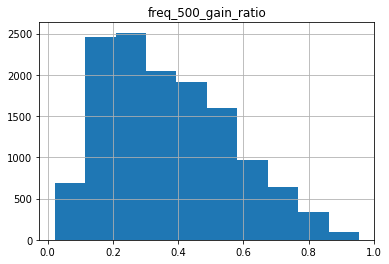

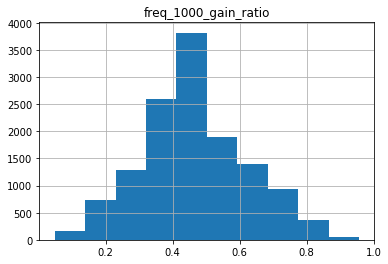

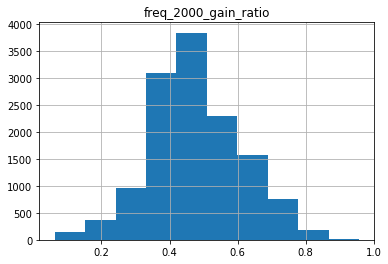

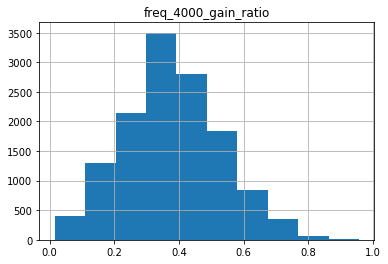

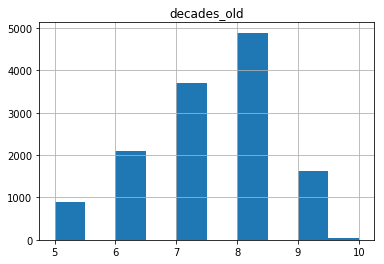

In [130]:
for feature in ['freq_500_gain_ratio', 'freq_1000_gain_ratio', 'freq_2000_gain_ratio', 'freq_4000_gain_ratio', 'decades_old']:
    display.display(equipment_success.hist(feature))

In [131]:
def scaleInner(df, feature):
    stats = df[feature].describe();
    std = stats['std']
    mean = stats['mean']
    df[feature + '_scaled'] = (df[feature] - mean)/std
    return df

def scale(df, features):
    scaledDf = df.copy()
    for feature in features:
        scaleInner(scaledDf, feature)
    return scaledDf        

In [132]:
def success_ratio(equipment_success, freq, multiplier, threshold ):
    data = pd.value_counts(
        equipment_success['freq_' + freq + '_gain'] > (equipment_success['freq_' + freq] * multiplier) - threshold
    )  
    return data[True]/(data[False] + data[True])

In [133]:
[success_ratio(equipment_success, '500', 0.5, 5),
success_ratio(equipment_success, '1000', 0.5, 5),
success_ratio(equipment_success, '2000', 0.5, 5),
success_ratio(equipment_success, '4000', 0.5, 5)]

[0.3628271856377763,
 0.6090367353096477,
 0.6254808780267028,
 0.3193030097307083]

In [134]:
def model_good_prediction_ratio(targets, predictions, max_distance):
    predictionsDiff = (targets - predictions).apply (lambda x: abs(x))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [135]:
def preprocess_features(df):
  """Prepares input features from a data set.

  Args:
    df: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """


  selected_features = scale(df, [ 
                                 'freq_500', 'freq_1000', 'freq_2000', 'freq_4000', 'months_since_equipped', 'decades_old'])
    
  selected_features = selected_features[
    [
     "isMale",
         "isFemale",
                 "isRightEar",
                         "isLeftEar",
     "decades_old_scaled",     
     "freq_500_scaled",
     "freq_1000_scaled",
     "freq_2000_scaled",
     "freq_4000_scaled",        
     "months_since_equipped_scaled",
    
    ]]
  processed_features = selected_features


  #processed_features["buck_average_loss"] = bucketized_average_loss
  #processed_features['x1'] = processed_features['average_loss'] * processed_features['high_loss']
  #processed_features['x2'] = processed_features['average_loss'] * processed_features['low_loss']
  #processed_features['x3'] = processed_features['high_loss'] * processed_features['low_loss']
  #processed_features['x4'] = processed_features['average_loss'] * processed_features['months_since_equipped']
  #processed_features['x5'] = processed_features['average_loss'] * processed_features['age_in_months_at_equipped_start']
  #processed_features['x6'] = processed_features['average_loss'] ** 2
  #processed_features['x7'] = processed_features['months_since_equipped'] ** 2
  #processed_features['x8'] = processed_features['age_in_months_at_equipped_start'] ** 2
  
  return processed_features

def preprocess_targets(df):
  """Prepares target features (i.e., labels) from a data set.

  Args:
    df: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets['eq_freq_500'] = df['eq_freq_500'] 
  output_targets['eq_freq_1000'] = df['eq_freq_1000'] 
  output_targets['eq_freq_2000'] = df['eq_freq_2000'] 
  output_targets['eq_freq_4000'] = df['eq_freq_4000'] 

  #output_targets['distance_from_target'] = ((df['eq_average_loss'] - df['average_loss']/2))
  #output_targets['target_reached'] = (df['eq_average_loss'] < df['average_loss']/2 + 5).astype('float')
    

  #output_targets['distance_from_target'] = ((df['eq_average_loss'] - df['average_loss']/2).apply (lambda x : max(x,0)))

  return output_targets

In [139]:
equipment_success = equipment_success.sample(frac=1)

total_samples = math.floor(equipment_success.count()['decades_old'] /3  )


examples = preprocess_features(equipment_success)
targets = preprocess_targets(equipment_success)

training_test_ratio = 0.8
training_samples = math.floor(total_samples*0.8)
validation_samples = total_samples - training_samples

[training_samples, validation_samples]

[3535, 884]

In [140]:
examples.describe()

,isMale,isFemale,isRightEar,isLeftEar,decades_old_scaled,freq_500_scaled,freq_1000_scaled,freq_2000_scaled,freq_4000_scaled,months_since_equipped_scaled
count,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0,13257.0
mean,0.3,0.4,0.5,0.5,0.0,0.0,0.0,0.0,-0.0,0.0
std,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0
min,0.0,0.0,0.0,0.0,-2.1,-2.2,-2.1,-2.6,-2.8,-1.1
25%,0.0,0.0,0.0,0.0,-0.3,-0.6,-0.7,-0.6,-0.7,-0.7
50%,0.0,0.0,1.0,0.0,-0.3,-0.2,-0.2,-0.1,-0.2,-0.3
75%,1.0,1.0,1.0,1.0,0.6,0.4,0.4,0.4,0.6,0.5
max,1.0,1.0,1.0,1.0,2.4,2.8,3.0,3.0,2.9,5.0


In [141]:
targets.describe()

,eq_freq_500,eq_freq_1000,eq_freq_2000,eq_freq_4000
count,13257.0,13257.0,13257.0,13257.0
mean,31.4,29.7,33.1,44.4
std,9.7,7.8,8.5,12.8
min,4.0,2.0,5.0,5.0
25%,25.0,25.0,30.0,35.0
50%,30.0,30.0,32.0,44.0
75%,35.0,35.0,36.0,50.0
max,100.0,100.0,100.0,105.0


In [142]:
training_examples = examples.head(training_samples).copy()
training_examples.describe()

,isMale,isFemale,isRightEar,isLeftEar,decades_old_scaled,freq_500_scaled,freq_1000_scaled,freq_2000_scaled,freq_4000_scaled,months_since_equipped_scaled
count,3535.0,3535.0,3535.0,3535.0,3535.0,3535.0,3535.0,3535.0,3535.0,3535.0
mean,0.3,0.4,0.5,0.5,0.0,0.1,0.0,0.0,0.0,-0.0
std,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0
min,0.0,0.0,0.0,0.0,-2.1,-2.1,-2.1,-2.6,-2.8,-1.1
25%,0.0,0.0,0.0,0.0,-0.3,-0.6,-0.7,-0.6,-0.7,-0.8
50%,0.0,0.0,1.0,0.0,0.6,-0.2,-0.2,-0.1,-0.2,-0.4
75%,1.0,1.0,1.0,1.0,0.6,0.7,0.4,0.4,0.6,0.5
max,1.0,1.0,1.0,1.0,2.4,2.8,2.7,2.7,2.9,4.9


In [143]:
validation_examples = examples.tail(validation_samples).copy()
validation_examples.describe()

,isMale,isFemale,isRightEar,isLeftEar,decades_old_scaled,freq_500_scaled,freq_1000_scaled,freq_2000_scaled,freq_4000_scaled,months_since_equipped_scaled
count,884.0,884.0,884.0,884.0,884.0,884.0,884.0,884.0,884.0,884.0
mean,0.3,0.3,0.5,0.5,-0.0,0.0,0.0,0.0,0.0,-0.0
std,0.4,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0
min,0.0,0.0,0.0,0.0,-2.1,-1.9,-1.9,-2.1,-2.5,-1.1
25%,0.0,0.0,0.0,0.0,-0.3,-0.6,-0.7,-0.6,-0.7,-0.7
50%,0.0,0.0,1.0,0.0,-0.3,-0.2,-0.2,-0.1,-0.2,-0.4
75%,1.0,1.0,1.0,1.0,0.6,0.4,0.4,0.4,0.6,0.5
max,1.0,1.0,1.0,1.0,2.4,2.8,2.7,2.7,2.4,4.6


In [144]:
training_targets = targets.head(training_samples)

In [145]:
validation_targets = targets.tail(validation_samples)

In [146]:
training_targets.describe()

,eq_freq_500,eq_freq_1000,eq_freq_2000,eq_freq_4000
count,3535.0,3535.0,3535.0,3535.0
mean,31.6,29.9,33.2,44.4
std,9.7,7.8,8.5,12.8
min,4.0,5.0,5.0,5.0
25%,25.0,25.0,30.0,35.0
50%,30.0,30.0,32.0,44.0
75%,38.0,35.0,36.0,50.0
max,90.0,70.0,100.0,105.0


In [147]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [150]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  deafness_levels = [20, 40, 55, 70, 80, 90]

  decades_old_scaled = tf.feature_column.numeric_column("decades_old_scaled")
  freq_500 = tf.feature_column.numeric_column("freq_500_scaled")
  freq_1000 = tf.feature_column.numeric_column("freq_1000_scaled")
  freq_2000 = tf.feature_column.numeric_column("freq_2000_scaled")
  freq_4000 = tf.feature_column.numeric_column("freq_4000_scaled")
  months_since_equipped_scaled = tf.feature_column.numeric_column("months_since_equipped_scaled")
   
  isMale =   tf.feature_column.numeric_column("isMale")
  isFemale =   tf.feature_column.numeric_column("isFemale")
  isRightEar =   tf.feature_column.numeric_column("isRightEar")
  isLeftEar =   tf.feature_column.numeric_column("isLeftEar")
  
  return set([
             freq_500,
      freq_1000, freq_2000, freq_4000, decades_old_scaled, isMale, isFemale, isRightEar, isLeftEar,
      months_since_equipped_scaled
  ])


In [182]:
def train_model(
    model_type,
    my_optimizer,
    steps,
    batch_size,
    label,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    hidden_units=[]):
  """Trains a regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `Regressor` object trained on the training data.
  """

  validation_targets= validation_targets[[label]]
  training_targets = training_targets[[label]]

  periods = 10
  steps_per_period = steps / periods
  
  print('hidden_units: '+ str(hidden_units))

  #my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)

 # my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  if model_type == 'linear':
      regressor = tf.estimator.LinearRegressor(
          feature_columns=construct_feature_columns(),
          optimizer=my_optimizer)
  elif model_type == 'neural_net':
      regressor = tf.estimator.DNNRegressor(
          feature_columns=construct_feature_columns(),
          hidden_units=hidden_units,
          optimizer=my_optimizer)
  else:
    raise Exception('Invalid model type:' + model_type)
  
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[label], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[label], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets[label], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
 
  label_sq_error=(training_targets[label] - training_targets[label].mean())**2
  initial_rmse=math.sqrt(label_sq_error.mean())
  initial_predict_ratio = model_good_prediction_ratio(targets, training_targets[label].mean(), 5)
  print("  Initial RMSE: %0.2f, Ratio: %0.2f" % ( initial_rmse, initial_predict_ratio))

    
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
    
    training_good_prediction_ratio = model_good_prediction_ratio(training_targets[label], training_predictions, 5)
    print("  period %02d -- RMSE: %0.2f, Ratio: %0.2f" % (period, training_root_mean_squared_error, training_good_prediction_ratio))
    
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return regressor, training_predictions, training_targets[label]

hidden_units: []
  Initial RMSE: 8.52, Ratio: 0.53
Training model...
RMSE (on training data):
  period 00 : 10.46
  period 00 -- RMSE: 10.46, Ratio: 0.40
  period 01 : 9.37
  period 01 -- RMSE: 9.37, Ratio: 0.45
  period 02 : 8.54
  period 02 -- RMSE: 8.54, Ratio: 0.48
  period 03 : 8.31
  period 03 -- RMSE: 8.31, Ratio: 0.51
  period 04 : 8.09
  period 04 -- RMSE: 8.09, Ratio: 0.53
  period 05 : 7.94
  period 05 -- RMSE: 7.94, Ratio: 0.54
  period 06 : 7.95
  period 06 -- RMSE: 7.95, Ratio: 0.53
  period 07 : 8.05
  period 07 -- RMSE: 8.05, Ratio: 0.52
  period 08 : 7.83
  period 08 -- RMSE: 7.83, Ratio: 0.54
  period 09 : 7.81
  period 09 -- RMSE: 7.81, Ratio: 0.54
Model training finished.


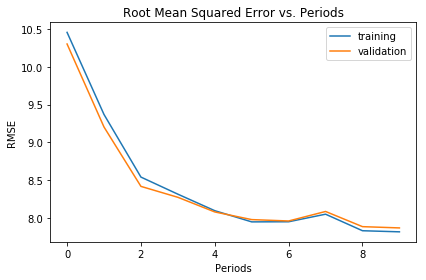

In [183]:
label='eq_freq_2000'

regressor, predictions, targets = train_model(
    model_type='linear',
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=3),
    steps=200,
    batch_size=10,
    label=label,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [184]:
training_targets.describe()

,eq_freq_500,eq_freq_1000,eq_freq_2000,eq_freq_4000
count,3535.0,3535.0,3535.0,3535.0
mean,31.6,29.9,33.2,44.4
std,9.7,7.8,8.5,12.8
min,4.0,5.0,5.0,5.0
25%,25.0,25.0,30.0,35.0
50%,30.0,30.0,32.0,44.0
75%,38.0,35.0,36.0,50.0
max,90.0,70.0,100.0,105.0


In [187]:
predictions

array([29.985855, 35.375282, 38.446884, ..., 30.322426, 35.60089 ,
       32.973198], dtype=float32)

hidden_units: [1]
  Initial RMSE: 8.52, Ratio: 0.53
Training model...
RMSE (on training data):
  period 00 : 8.52
  period 00 -- RMSE: 8.52, Ratio: 0.53
  period 01 : 8.54
  period 01 -- RMSE: 8.54, Ratio: 0.53
  period 02 : 8.52
  period 02 -- RMSE: 8.52, Ratio: 0.53
  period 03 : 8.52
  period 03 -- RMSE: 8.52, Ratio: 0.53
  period 04 : 8.53
  period 04 -- RMSE: 8.53, Ratio: 0.53
  period 05 : 8.54
  period 05 -- RMSE: 8.54, Ratio: 0.53
  period 06 : 8.52
  period 06 -- RMSE: 8.52, Ratio: 0.53
  period 07 : 8.53
  period 07 -- RMSE: 8.53, Ratio: 0.53
  period 08 : 8.52
  period 08 -- RMSE: 8.52, Ratio: 0.53
  period 09 : 8.52
  period 09 -- RMSE: 8.52, Ratio: 0.53
Model training finished.


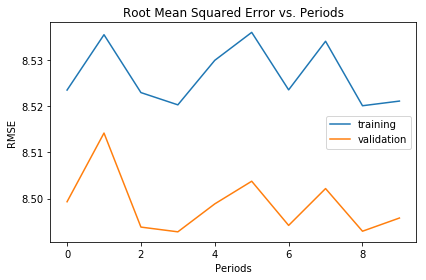

In [188]:
regressor, predictions, targets = train_model(
    model_type='neural_net',
    hidden_units=[1],
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=5),
    steps=1000,
    batch_size=20,
    label='eq_freq_2000',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
[model_good_prediction_ratio(targets, predictions, 5), model_good_prediction_ratio(targets, training_targets.describe()['eq_average_loss']['mean'], 5)]

In [ ]:
training_targets.describe()

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import optimizers

model = Sequential([
    Dense(4, input_dim=4),
    Activation('linear'),
    Dense(1),
])

#inputs = Input(shape=(4,))
#preds = Dense(4,activation='linear')(inputs)
#model = Model(inputs=inputs,outputs=preds)


sgd = optimizers.SGD()


model.compile(optimizer=sgd,
              loss='mse',       
              metrics=['mse'])  

features = [
    #'age_in_months_at_equipped_start',
    #'gender', 
                      'freq_500_scaled',
    'freq_1000_scaled',
    'freq_2000_scaled', 
    'freq_4000_scaled']
                         
data = (training_examples[features].values)
labels = (training_targets['eq_freq_500'].values)

validation_data = validation_examples[features].values
validation_labels = validation_targets.values
model.fit(data, labels, epochs=10, batch_size=10,
          validation_data=(data, labels))

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sgd=keras.optimizers.SGD()


model = Sequential()
model.add(Dense(2, activation='relu', input_dim=2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=sgd,
              loss='mse',)

model = Model(inputs=)

# Generate dummy data
import numpy as np
data = np.random.random((10, 2))
labels = np.random.randint(2, size=(10, 1))

data = sc.fit_transform(np.asarray([[1.,2.], [3., 4.], [5., 6.]]))
labels =  sc.fit_transform(np.asarray([1.5,3.5, 5.5]))

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(data, labels, epochs=10, batch_size=2, verbose=1)

In [ ]:
inputs = Input(shape=(1,))
preds = Dense(1,activation='linear')(inputs)

model = Model(inputs=inputs,outputs=preds)
sgd = optimizers.SGD()
x = np.asarray([1., 2., 3.])
y = np.asarray([1.2, 2.2, 3.2])
model.compile(optimizer=sgd ,loss='mse')
model.fit(x,y, batch_size=1, verbose=1, epochs=10, shuffle=False)
plt.scatter(x,y,color='black')
plt.plot(x,model.predict(x), color='blue', linewidth=3)

In [ ]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    label,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[label], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[label], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[label], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.3f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [ ]:
data = sc.fit_transform(np.asarray([[1.,2.], [3., 4.], [5., 6.]]))

data

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(data).transpose()[0]
labels.shape

In [ ]:
predictions

In [ ]:
data

In [ ]:
labels -predictions

In [ ]:
map(labels - predictions, lambda x: abs(x))
1

In [ ]:
def model_good_prediction_ratio_array(targets, predictions, max_distance):
    predictionsDiff = (targets - predictions) (lambda x: abs(x))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [ ]:
[model_good_prediction_ratio_array(labels, result, 5), model_good_prediction_ratio(targets, training_targets.describe()['eq_average_loss']['mean'], 5)]

In [ ]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.0005,
    steps=600,
    batch_size=200,
    label='target_reached',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["target_reached"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
evaluation_metrics

In [ ]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

precision, recall, thresholds = metrics.precision_recall_curve(
    validation_targets, validation_probabilities)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precison vs. Recall")
_ = plt.show()

In [ ]:
validation_probabilities

In [ ]:
validation_targets['target_reached'].values

In [ ]:
pd.value_counts(validation_targets['target_reached'])

In [ ]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
_ = plt.legend(loc=2)

In [ ]:
 predict_training_input_fn = lambda: my_input_fn(
  training_examples, 
  training_targets['eq_average_loss'], 
  num_epochs=1, 
  shuffle=False)
    
training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['predictions'][0] for item in training_predictions])

training_predictions

In [ ]:
plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.ylim(0, 60)
plt.xlim(0, 60)
plt.plot([0, 60], [0, 60], label="random classifier")

plt.scatter(targets, predictions )

In [ ]:
pd.DataFrame({'x': predictions})['x'].hist()

In [ ]:
pd.DataFrame({'x': targets})['x'].hist()

In [ ]:
pd.DataFrame({'x': (targets - predictions).apply (lambda x: abs(x))})['x'].describe()

In [ ]:
pd.DataFrame({'x': (targets - 34.4).apply (lambda x: abs(x))})['x'].describe()

In [ ]:
pd.DataFrame({'x': (targets - predictions).apply (lambda x: abs(x))})['x'].hist()

In [ ]:
pd.DataFrame({'x': (targets - 34.4).apply (lambda x: abs(x))})['x'].hist()